<a href="https://colab.research.google.com/github/nicslevelcode/nicslevelAI/blob/master/HDB_Resale_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project aims to explore machine learning using HDB prices from Jan 2017 to Mar 2020
<br> Dataset extracted from: https://data.gov.sg/dataset/resale-flat-prices
<br> Licence: Singapore Open Data Licence

![alt text](https://www.onlinecitizenasia.com/wp-content/uploads/2018/09/featured-image-public-housing-750x375.png)

# Conclusion

The best performing model in the notebook, XGBoost Model provides R2 of **0.917**
<br> Features utilized in no particular order of importance include:
- **flat_type**: *2 room, 3 room etc*
- **town**: *Ang Mo Kio, Bishan etc*
- **floor_area_sqm**: *floor area in square meters*
- **flat_model**: *New Generation, DBSS etc*
- **lease_remaining**: *number of years remaining on the leasehold*
- **storey_range**: *floor number*

Further understanding
- Explore the blackbox further and understand the logic behind the results
- Extracting which features have the most impact on your flat

Future improvements
- add features that can be gotten online (distance from MRT, distance from nearby attactions)
- add other features that may help (condition of flat, existing renovation, furnishings, property news, property market sentiment, macro economic factors)
- add more data from other time periods to be able to forecast future prices / time series analysis
- allow a user to input certain fields and get a price prediction
- link API directly from data.gov.sg
- visualize ouputs

# Basic Imports

In [0]:
#Import Libraries
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
pd.set_option('display.max_columns', None)

import numpy as np
from datetime import date
from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import files
uploaded = files.upload()
train=pd.read_csv('resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

Saving resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv to resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv


# Output Variable

count     70103.000
mean     438399.819
std      153319.471
min      140000.000
25%      328888.000
50%      407000.000
75%      510000.000
max     1232000.000
Name: resale_price, dtype: float64
Skewness: 1.138467
Kurtosis: 1.291612


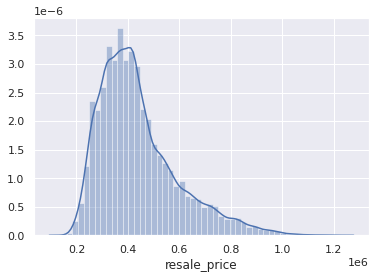

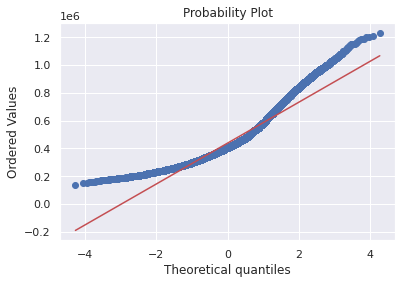

In [0]:
output_var_name = 'resale_price'
output_var = train[output_var_name]
print(output_var.describe())
sns.distplot(output_var)
print("Skewness: %f" % output_var.skew())
print("Kurtosis: %f" % output_var.kurt())
fig = plt.figure()
res = stats.probplot(train[output_var_name], plot=plt)
plt.show()


 mu = 12.94 and sigma = 0.33



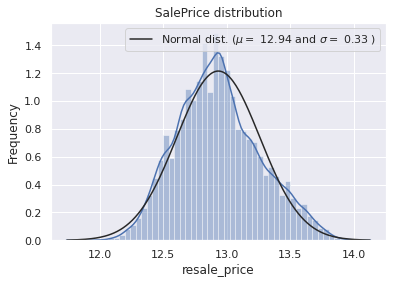

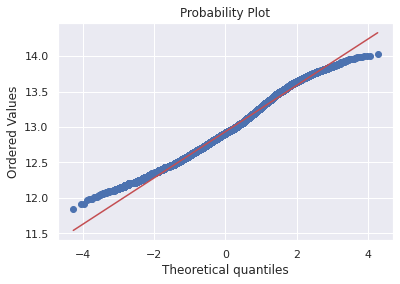

In [0]:
train[output_var_name] = np.log1p(train[output_var_name])
sns.distplot(train[output_var_name] , fit=norm);

(mu, sigma) = norm.fit(train[output_var_name])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train[output_var_name], plot=plt)
plt.show()

# EDA

In [0]:
print(train.head())
print(train.describe())

print(train.info())

     month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0          44.000        Improved                 1979  61 years 04 months   
1          67.000  New Generation                 1978  60 years 07 months   
2          67.000  New Generation                 1980  62 years 05 months   
3          68.000  New Generation                 1980   62 years 01 month   
4          67.000  New Generation                 1980  62 years 05 months   

   resale_price  
0        12.354  
1        12.429  
2        12.476  
3        12.48

In [0]:
# We will approximate the remaining lease by years

# Create new column for Lease remaining
today=date.today().year
print(today)
train['lease_remaining']=today-train['lease_commence_date']
# sanity check on newly created data
print(train.lease_remaining.describe())
# drop the existing data
train = train.drop(['lease_commence_date'],axis=1)

2020
count   70103.000
mean       26.205
std        12.585
min         4.000
25%        17.000
50%        27.000
75%        36.000
max        54.000
Name: lease_remaining, dtype: float64


In [0]:
# Extracting year and month
train['year'] = pd.DatetimeIndex(train['month']).year
train['month'] = pd.DatetimeIndex(train['month']).month

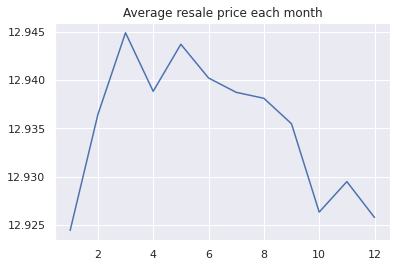

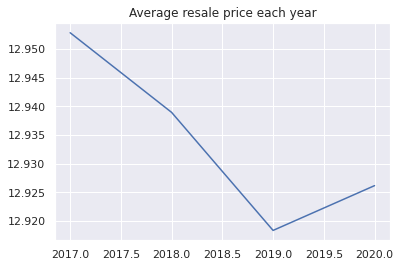

In [0]:
monthly_sales = train.groupby('month').agg({'resale_price':'mean'})
plt.plot(monthly_sales)
plt.title('Average resale price each month')
plt.show()

yearly_sales = train.groupby('year').agg({'resale_price':'mean'})
plt.plot(yearly_sales)
plt.title('Average resale price each year')
plt.show()

Very slight difference in prices based on time periods ~2.5% (10,000 / 400,000)
<br> There appears to be some slight monthly seasonal trends 
<br> Possible to drop these features

                 month  floor_area_sqm  resale_price  lease_remaining   year
resale_price    -0.008           0.691         1.000           -0.368 -0.039
floor_area_sqm   0.004           1.000         0.691           -0.202 -0.016
month            1.000           0.004        -0.008           -0.007 -0.214
year            -0.214          -0.016        -0.039           -0.073  1.000
lease_remaining -0.007          -0.202        -0.368            1.000 -0.073


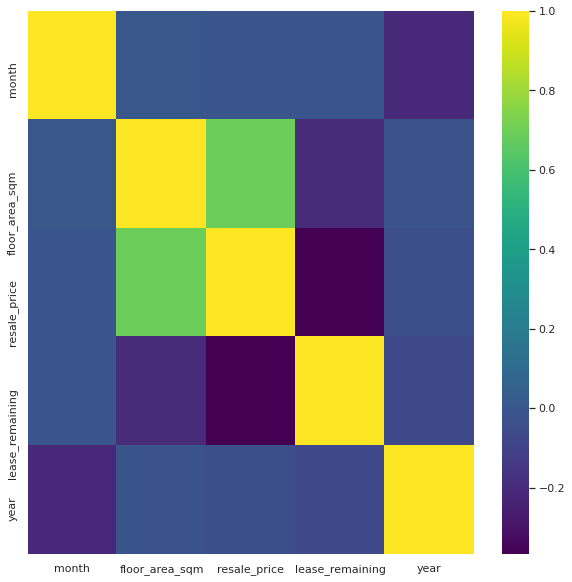

In [0]:
corr = train.corr()
corr.sort_values([output_var_name], ascending = False, inplace = True)#
print(corr)

ax = plt.subplots(ncols=1, figsize=(10,10))
corr_matrix = train.corr()
sns.heatmap(corr_matrix,cmap='viridis')
plt.show()

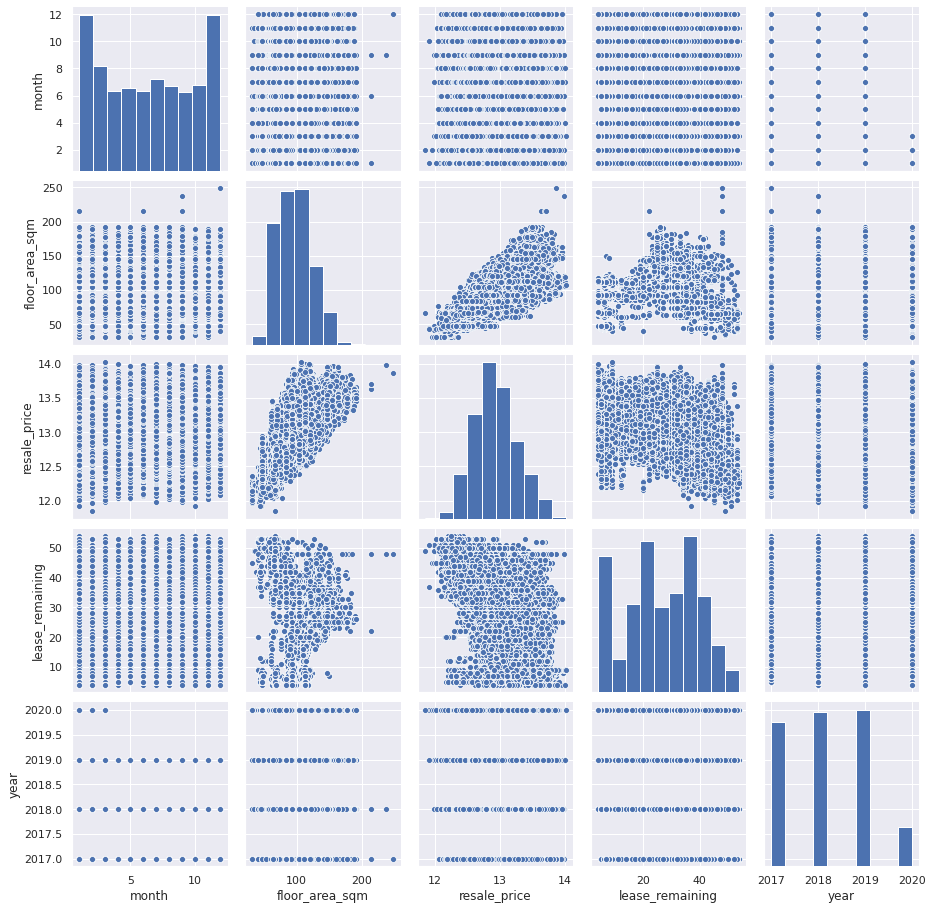

In [0]:
sns.set()
sns.pairplot(train, height = 2.5)
plt.show()

no significant outliers

In [0]:
df_not_num = train.select_dtypes(include = ['O'])
# we will drop remaining_lease, block and street_name since we are not using these features
df_not_num = df_not_num.drop(['block','remaining_lease','street_name'],axis=1)

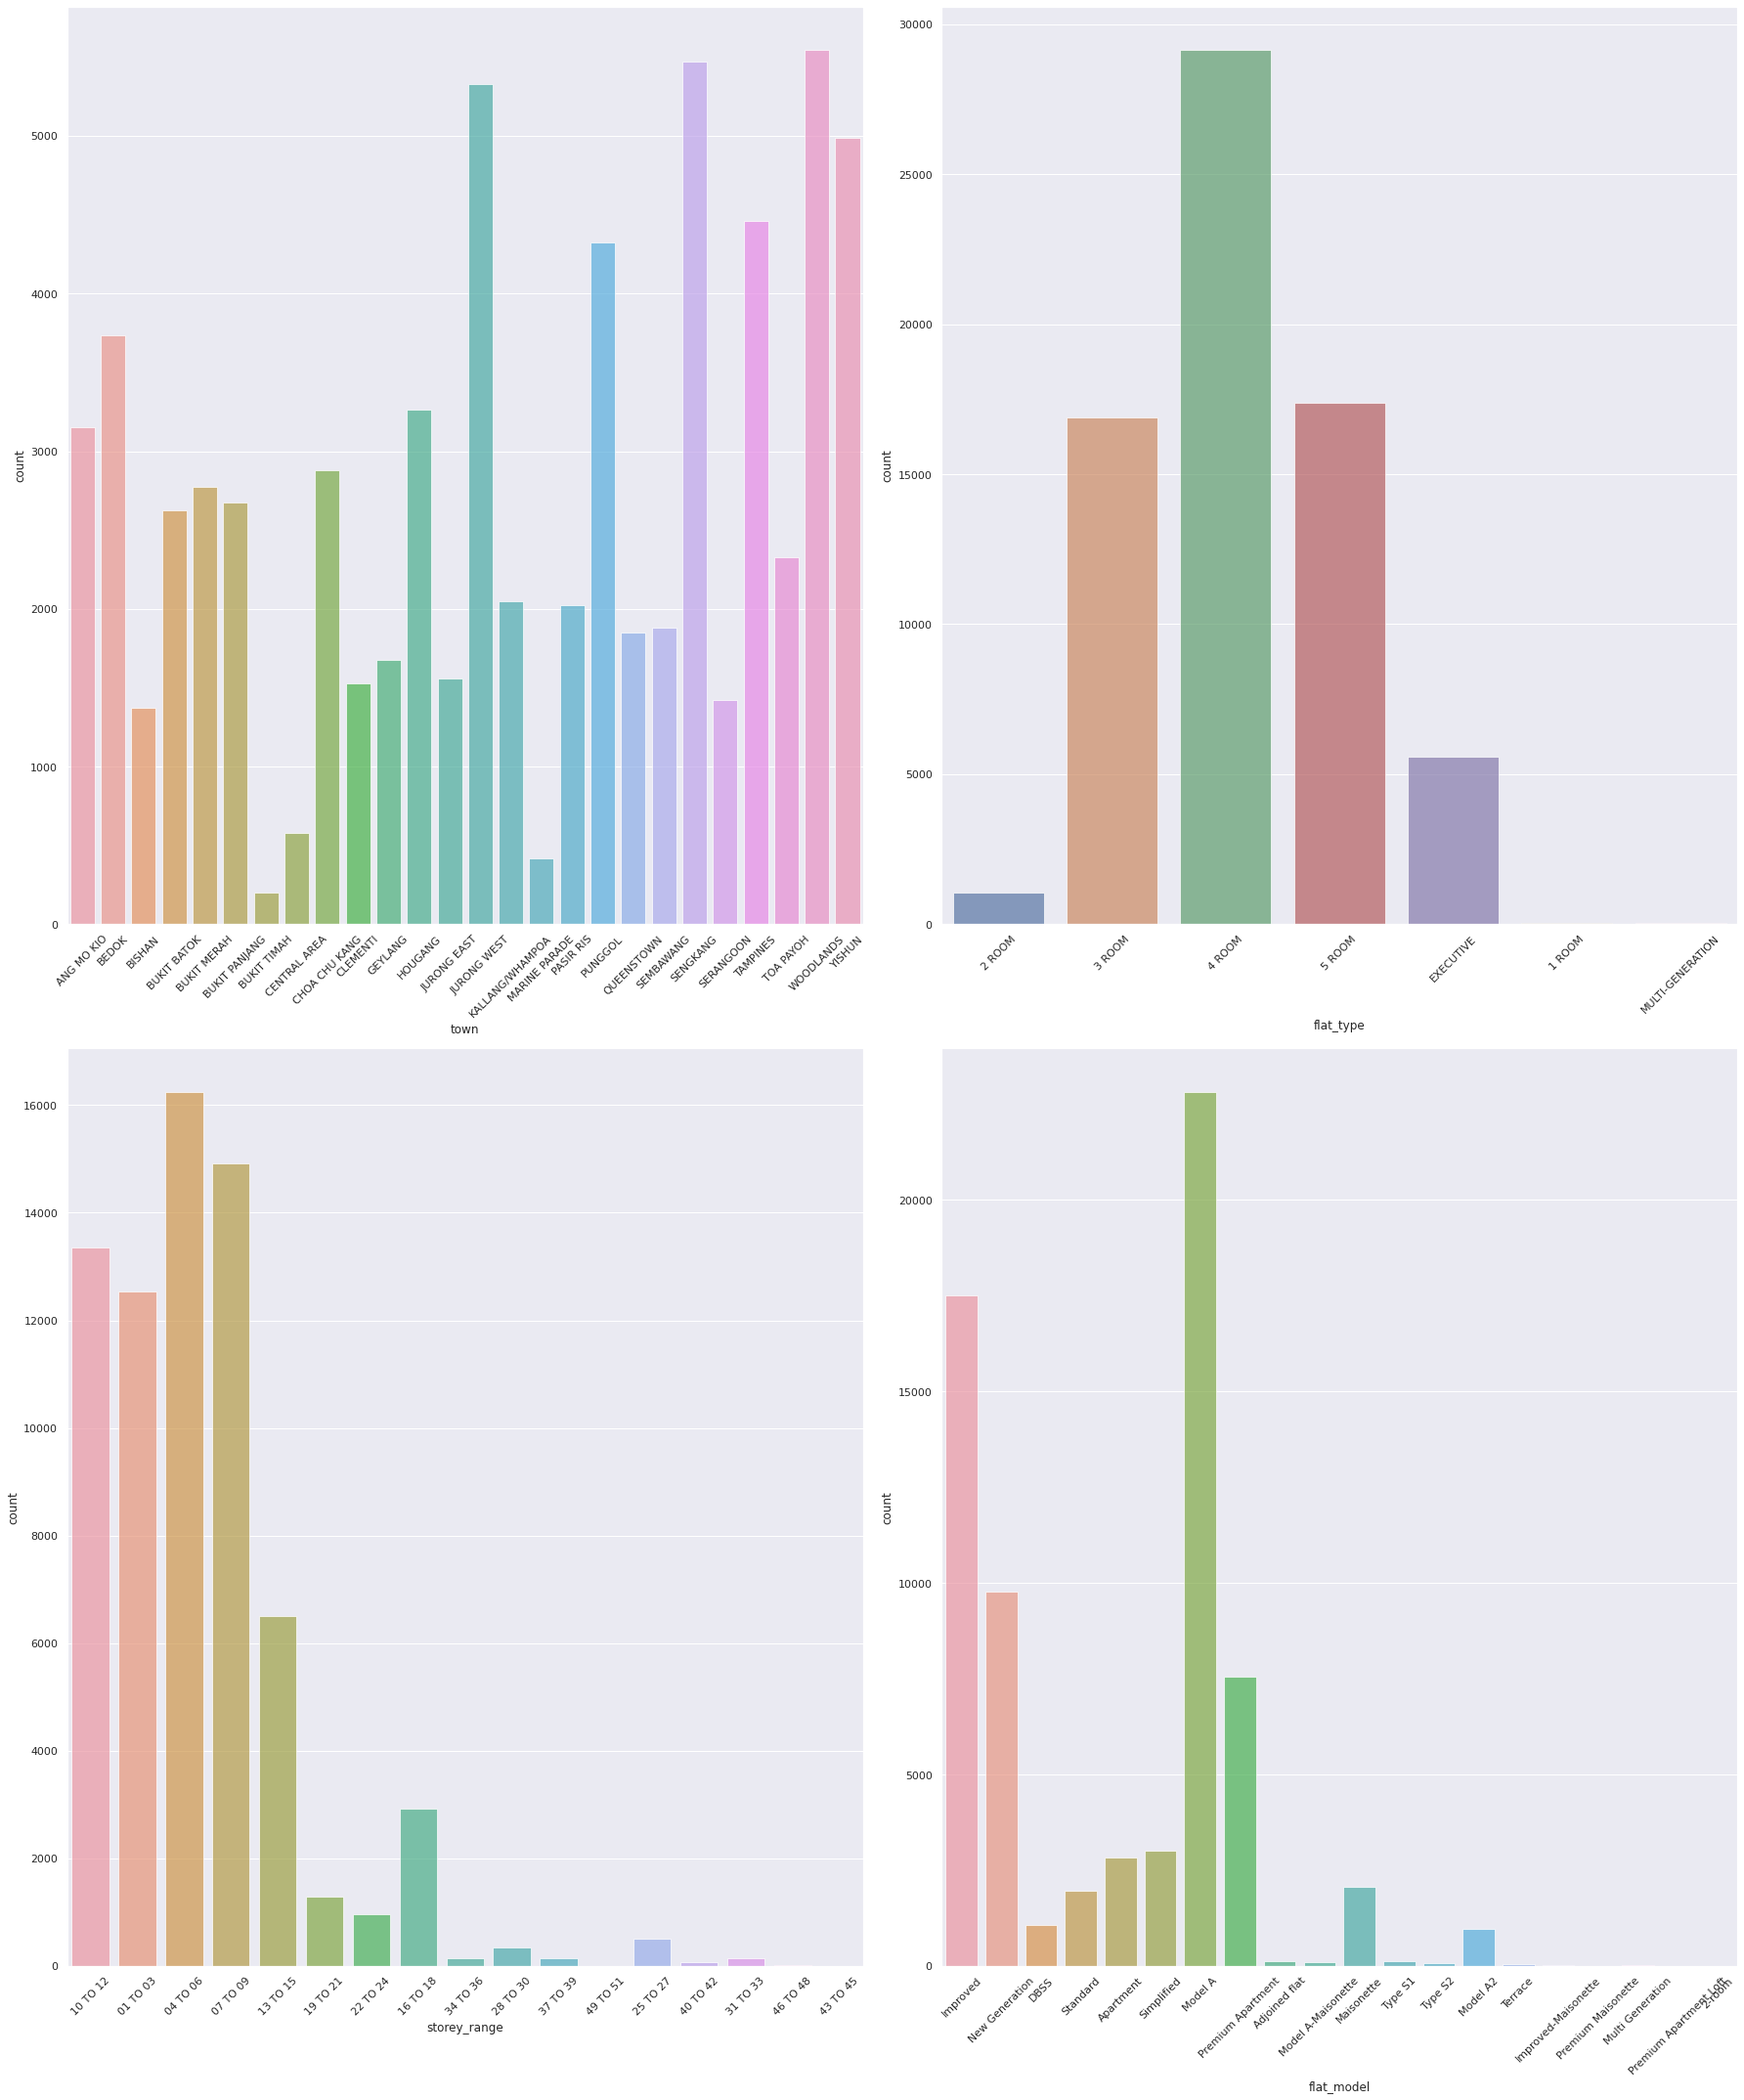

In [0]:
fig, axes = plt.subplots(round(len(df_not_num.columns) / 2), 2, figsize=(25, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_not_num.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)

fig.tight_layout()

In [0]:
for i in df_not_num:
  print(train[i].value_counts())

WOODLANDS          5543
SENGKANG           5472
JURONG WEST        5327
YISHUN             4990
TAMPINES           4462
PUNGGOL            4322
BEDOK              3732
HOUGANG            3265
ANG MO KIO         3154
CHOA CHU KANG      2879
BUKIT MERAH        2774
BUKIT PANJANG      2676
BUKIT BATOK        2627
TOA PAYOH          2328
KALLANG/WHAMPOA    2049
PASIR RIS          2022
SEMBAWANG          1878
QUEENSTOWN         1849
GEYLANG            1678
JURONG EAST        1556
CLEMENTI           1529
SERANGOON          1421
BISHAN             1375
CENTRAL AREA        581
MARINE PARADE       416
BUKIT TIMAH         198
Name: town, dtype: int64
4 ROOM              29131
5 ROOM              17381
3 ROOM              16903
EXECUTIVE            5582
2 ROOM               1041
MULTI-GENERATION       33
1 ROOM                 32
Name: flat_type, dtype: int64
04 TO 06    16243
07 TO 09    14917
10 TO 12    13361
01 TO 03    12537
13 TO 15     6505
16 TO 18     2932
19 TO 21     1296
22 TO 24     

# Missing Data

In [0]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(20)

,Missing Ratio


No missing data

# Modelling

In [0]:
# Preprocessing
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
# Training and tuning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
# Algorithms
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

# Scorer
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, r2_score

In [0]:
features = ['flat_type','town','floor_area_sqm','flat_model','lease_remaining','storey_range']
model_df = train[features]

## Baseline Simple Linear Regression

In [0]:
numerical_features = model_df.select_dtypes(include=['int64','float64']).columns
categorical_features = model_df.select_dtypes(include=['object']).columns

preprocess = make_column_transformer(
       (make_pipeline(StandardScaler()), numerical_features),
       (make_pipeline(OneHotEncoder()), categorical_features))

training_set_pp = preprocess.fit_transform(model_df)

In [0]:
output_var = train[output_var_name]
X_train, X_test, y_train, y_test = train_test_split(
    training_set_pp,
    output_var,
    test_size=0.2,
    random_state=42,
    shuffle=True
    )

In [0]:
LR=LinearRegression()
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.5f}".format(r2))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.2f}".format(rmse))

R2 Score: 0.84032
RMSE: 0.13


## Regularization

In [0]:
Las = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Las.fit(X_train,y_train)
y_pred=Las.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.5f}".format(r2))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.2f}".format(rmse))

R2 Score: 0.80767
RMSE: 0.14


In [0]:
ridge = Ridge(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
ridge.fit(X_train,y_train)
y_pred=ridge.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.5f}".format(r2))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.2f}".format(rmse))

R2 Score: 0.84020
RMSE: 0.13


Model seems underfitted so we will try boosting/ensembling techniques

In [0]:
model = xgb.XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=None, n_estimators=1000, n_jobs=0,
             nthread=None, num_parallel_tree=1, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [0]:
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.5f}".format(r2))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.2f}".format(rmse))

R2 Score: 0.92831
RMSE: 0.09


In [0]:
GBoost = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='huber',
                          max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=1250,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=5, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
GBoost.fit(X_train,y_train)
y_pred=GBoost.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.5f}".format(r2))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.2f}".format(rmse))

R2 Score: 0.92322
RMSE: 0.09


# Tuning

In [0]:
alpha=[0.01,0.001,0.0075,0.005]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'alpha': alpha,
    }
random_cv = RandomizedSearchCV(estimator=Las,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv.fit(X_train,y_train)
print(random_cv.best_estimator_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  18 out of  20 | elapsed:    4.9s remaining:    0.5s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    5.0s finished


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


In [0]:
alpha=[0.01,0.001,0.0075,0.005]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'alpha': alpha,
    }
random_cv = RandomizedSearchCV(estimator=ridge,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv.fit(X_train,y_train)
print(random_cv.best_estimator_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Ridge(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)


[Parallel(n_jobs=4)]: Done  18 out of  20 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.8s finished


In [0]:
n_estimators = [500, 1000, 250, 750, 1250]
max_depth = [2, 3, 5, 7, 10]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.2]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }
random_cv = RandomizedSearchCV(estimator=model,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv.fit(X_train,y_train)
print(random_cv.best_estimator_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  9.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 22.2min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 35.2min finished


XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=None, n_estimators=1000, n_jobs=0,
             nthread=None, num_parallel_tree=1, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)


In [0]:
n_estimators = [500, 1000, 250, 750, 1250]
learning_rate=[0.05,0.1,0.15,0.2]
max_depth=[2,3,4,5]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    }
random_cv = RandomizedSearchCV(estimator=GBoost,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv.fit(X_train,y_train)
print(random_cv.best_estimator_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 13.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 35.9min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 60.0min finished


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='huber',
                          max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=1250,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=5, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


# Let's investigate the power of AutoML in Azure
AutoML can help us tune and find the best model more efficiently
<br> https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-first-experiment-automated-ml

First lets export the data

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70103 entries, 0 to 70102
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   month            70103 non-null  int64  
 1   town             70103 non-null  object 
 2   flat_type        70103 non-null  object 
 3   block            70103 non-null  object 
 4   street_name      70103 non-null  object 
 5   storey_range     70103 non-null  object 
 6   floor_area_sqm   70103 non-null  float64
 7   flat_model       70103 non-null  object 
 8   remaining_lease  70103 non-null  object 
 9   resale_price     70103 non-null  float64
 10  lease_remaining  70103 non-null  int64  
 11  year             70103 non-null  int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 6.4+ MB


In [0]:
export = pd.concat([train,output_var],axis=1)

In [0]:
export.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70103 entries, 0 to 70102
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   month            70103 non-null  int64  
 1   town             70103 non-null  object 
 2   flat_type        70103 non-null  object 
 3   block            70103 non-null  object 
 4   street_name      70103 non-null  object 
 5   storey_range     70103 non-null  object 
 6   floor_area_sqm   70103 non-null  float64
 7   flat_model       70103 non-null  object 
 8   remaining_lease  70103 non-null  object 
 9   resale_price     70103 non-null  float64
 10  lease_remaining  70103 non-null  int64  
 11  year             70103 non-null  int64  
 12  resale_price     70103 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 7.0+ MB


In [0]:
export.to_csv('export.csv') 
files.download('export.csv')